In [1]:
# We define the data transformations and loaders to load the images and their corresponding
# labels from the training folder. We use the Adam optimizer and cross-entropy loss function for training.
# Finally, we train the model for 10 epochs and save the model weights.
# The training data is loaded using PyTorch's DataLoader, and the model is trained using the Adam optimizer and
# cross-entropy loss. The trained model is then saved to a file for evaluation or later use.

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from model import GenderClassifier

In [28]:
# Define the data transformations and loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder('mfc_dataset_train_test/train', transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
classes = train_loader.dataset.classes

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cpu


Feature batch shape: torch.Size([32, 3, 12, 98])
Labels batch shape: torch.Size([32])


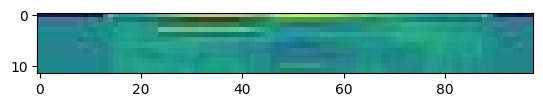

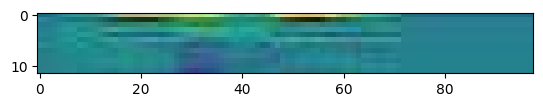

Label: 0 = female
Label: 1 = male


In [29]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = np.einsum('cxy->xyc', train_features[0])
plt.imshow(img)
plt.show()
img = np.einsum('cxy->xyc', train_features[1])
plt.imshow(img)
plt.show()
print(f"Label: {0} = {classes[0]}")
print(f"Label: {1} = {classes[1]}")

In [32]:
def run_and_save_model(num_epochs, l_rate):
    print(f'Running model with {num_epochs} epochs, learning rate {l_rate}')

    # Initialize the model, loss function, and optimizer
    model = GenderClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=l_rate)

    # Train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (data, labels) in enumerate(train_loader, 0):
            inputs, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

    # Save the model
    torch.save(model.state_dict(), f'saved_model/weights_{num_epochs}_{l_rate}.pth')

In [33]:
for epochs in [5, 10]:
    for learning_rate in [0.001, 0.0001, 0.00001]:
        run_and_save_model(epochs, learning_rate)

Running model with 5 epochs, learning rate 0.001
Epoch 1, Loss: 0.4431631588419099
Epoch 2, Loss: 0.6330470134631678
Epoch 3, Loss: 0.9274812379298499
Epoch 4, Loss: 0.6937397800314541
Epoch 5, Loss: 0.6987062283217336
Running model with 5 epochs, learning rate 0.0001
Epoch 1, Loss: 0.5802390017006502
Epoch 2, Loss: 0.6942058575039093
Epoch 3, Loss: 0.6940547968632877
Epoch 4, Loss: 0.6940124470966692
Epoch 5, Loss: 0.6939924646871158
Running model with 5 epochs, learning rate 1e-05
Epoch 1, Loss: 0.723494213562423
Epoch 2, Loss: 0.695171541299302
Epoch 3, Loss: 0.6917106431132307
Epoch 4, Loss: 0.6947527145044491
Epoch 5, Loss: 0.6945822737849178
Running model with 10 epochs, learning rate 0.001
Epoch 1, Loss: 0.473073807997702
Epoch 2, Loss: 0.7664626752198508
Epoch 3, Loss: 0.7013706719672409
Epoch 4, Loss: 0.8278905578885978
Epoch 5, Loss: 0.7276677804442641
Epoch 6, Loss: 0.724084685824197
Epoch 7, Loss: 0.7480120724572922
Epoch 8, Loss: 0.7339578420399858
Epoch 9, Loss: 0.7169473

In [34]:
from sklearn.metrics import confusion_matrix

def evaluate_model(num_epochs, l_rate):
    print(f'Testing model with {num_epochs} epochs, learning rate {l_rate}')

    # Test the model
    model = GenderClassifier().to(device)
    model.load_state_dict(torch.load(f'saved_model/weights_{num_epochs}_{l_rate}.pth'))
    model.eval()

    test_set = datasets.ImageFolder('mfc_dataset_train_test/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

    cm = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader, 0):
            inputs, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            cm += confusion_matrix(labels, predicted, labels=[0, 1])

    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    acc = np.sum(np.diag(cm) / np.sum(cm))
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)

    print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
    print()
    print('Confusion Matrix : ')
    print(cm)
    print('- Sensitivity : ', (tp / (tp + fn)) * 100)
    print('- Specificity : ', (tn / (tn + fp)) * 100)
    print('- Precision: ', (tp / (tp + fp)) * 100)
    print('- NPV: ', (tn / (tn + fn)) * 100)
    print('- F1 : ', ((2 * sensitivity * precision) / (sensitivity + precision)) * 100)
    print()

In [35]:
for epochs in [5, 10]:
    for learning_rate in [0.001, 0.0001, 0.00001]:
        evaluate_model(epochs, learning_rate)

Testing model with 5 epochs, learning rate 0.001
*****
tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 0, 1, 

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:40: RuntimeWarning: invalid value encountered in long_scalars
  print('- NPV: ', (tn / (tn + fn)) * 100)


*****
tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:31: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:39: RuntimeWarning: invalid value encountered in long_scalars
  print('- Precision: ', (tp / (tp + fp)) * 100)


*****
tensor([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:40: RuntimeWarning: invalid value encountered in long_scalars
  print('- NPV: ', (tn / (tn + fn)) * 100)


*****
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:40: RuntimeWarning: invalid value encountered in long_scalars
  print('- NPV: ', (tn / (tn + fn)) * 100)


*****
tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
*****
tensor([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:40: RuntimeWarning: invalid value encountered in long_scalars
  print('- NPV: ', (tn / (tn + fn)) * 100)


*****
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 1, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
*****
tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1

/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:31: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)
/var/folders/nr/6rkfgfhn2w14qvhm63zzh23m0000gn/T/ipykernel_3808/1379352361.py:39: RuntimeWarning: invalid value encountered in long_scalars
  print('- Precision: ', (tp / (tp + fp)) * 100)
